In [2]:
import os
import cv2
from  tqdm  import  tqdm 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
import random
from skimage import feature as ft
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from xgboost import XGBClassifier
import xgboost
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import NuSVC, SVC
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
#可直接切 但是效果不好
import cv2
import numpy as np

# 读取图像
image = cv2.imread('h02060.jpg', cv2.IMREAD_GRAYSCALE)

# 二值化处理
_, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)

# 寻找轮廓
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 定义一个计数器
counter = 0

# 遍历轮廓并切割
for contour in contours:
    # 计算轮廓的边界框
    x, y, w, h = cv2.boundingRect(contour)
    
    # 根据边界框切割图像
    rect = image[y:y+h, x:x+w]
    
    # 保存或处理切割后的图像
    cv2.imwrite('character_{}.jpg'.format(counter), rect)
    
    # 更新计数器
    counter += 1


In [ ]:
# 显示结果
cv2.imshow('Result', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [1]:
#可切 但效果不好
import cv2

# 读取图像
image = cv2.imread('h02060.jpg')

# 灰度化
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# 二值化处理
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# 寻找轮廓
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 遍历轮廓并切割
for i, contour in enumerate(contours):
    # 计算轮廓的边界框
    x, y, w, h = cv2.boundingRect(contour)
    
    # 根据边界框切割图像
    rect = image[y:y+h, x:x+w]
    
    # 保存切割后的图像
    cv2.imwrite('carving_{}.jpg'.format(i), rect)


In [3]:
#基本逻辑这样 但运行有问题

import os
import json
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# 加载数据集
def load_dataset(image_folder, annotation_folder):
    dataset = []
    image_files = sorted(os.listdir(image_folder))
    annotation_files = sorted(os.listdir(annotation_folder))
    for image_file, annotation_file in zip(image_files, annotation_files):
        if image_file.endswith('.jpg') and annotation_file.endswith('.json'):
            image_path = os.path.join(image_folder, image_file)
            annotation_path = os.path.join(annotation_folder, annotation_file)
            image = cv2.imread(image_path)
            annotation = json.load(open(annotation_path))
            dataset.append({'image': image, 'annotation': annotation})
    return dataset

# 数据预处理
def preprocess_data(dataset):
    images = []
    masks = []
    for data in dataset:
        image = cv2.resize(data['image'], (256, 256))
        mask = np.zeros((256, 256), dtype=np.uint8)
        for region in data['annotation']['regions']:
            x = region['shape_attributes']['all_points_x']
            y = region['shape_attributes']['all_points_y']
            points = np.array(list(zip(x, y)), np.int32)
            cv2.fillPoly(mask, [points], 255)
        images.append(image)
        masks.append(mask)
    return np.array(images), np.array(masks)

# 创建模型
def create_model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 训练模型
def train_model(model, images, masks, epochs=10, batch_size=32):
    model.fit(images, masks, epochs=epochs, batch_size=batch_size)

# 加载数据集
dataset = load_dataset('Train', 'Train')

# 数据预处理
images, masks = preprocess_data(dataset)

# 创建并训练模型
model = create_model(input_shape=(256, 256, 3))
train_model(model, images, masks)

# 保存模型
model.save('segmentation_model.h5')


Epoch 1/10


2024-04-12 19:36:19.582254: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


ValueError: Unexpected result of `train_function` (Empty logs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

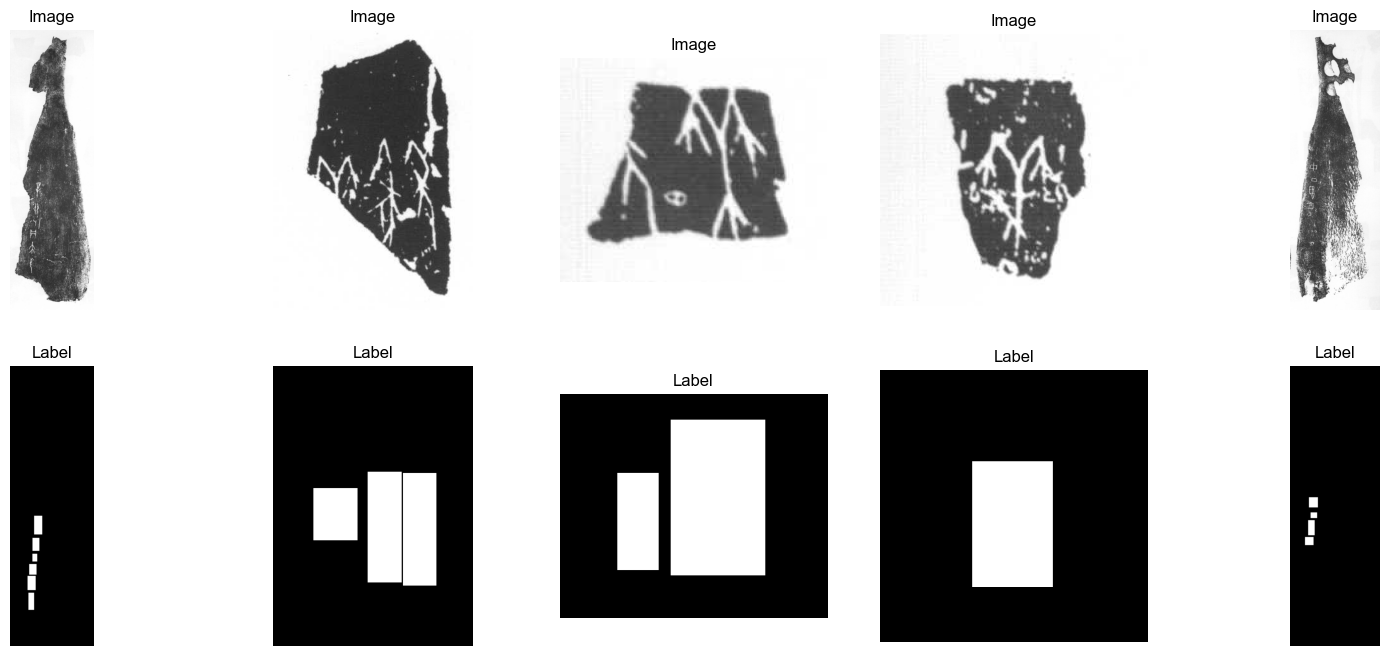

In [5]:
#输出5张图片，如果需要输出更多 需要调参数
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 定义函数加载图像和标签数据
def load_data(data_dir):
    images = []
    labels = []
    
    # 遍历数据文件夹中的每个JSON文件
    for json_file in os.listdir(data_dir):
        if json_file.endswith('.json'):
            with open(os.path.join(data_dir, json_file), 'r') as f:
                data = json.load(f)
                img_name = data['img_name']
                
                # 读取图像
                img_path = os.path.join(data_dir, img_name + '.jpg')
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
                images.append(img)
                
                # 读取标签数据
                annotations = data['ann']
                label = np.zeros_like(img[:,:,0], dtype=np.uint8)
                for ann in annotations:
                    x1, y1, x2, y2, _ = ann
                    label[int(y1):int(y2), int(x1):int(x2)] = 1
                labels.append(label)
    
    return images, labels

# 加载数据
data_dir = "Train"
images, labels = load_data(data_dir)

# 可视化示例图像和相应的标签数据
def visualize_data(images, labels):
    num_samples = len(images)
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    for i in range(5):
        axes[0, i].imshow(images[i])
        axes[0, i].set_title("Image")
        axes[0, i].axis('off')
        axes[1, i].imshow(labels[i], cmap='gray')
        axes[1, i].set_title("Label")
        axes[1, i].axis('off')
    plt.show()

# 可视化示例图像和标签数据
visualize_data(images, labels)


In [6]:
!pip install torch -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 MB 1.1 MB/s eta 0:00:0000:0100:02m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 945.4 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 676.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 621.7 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0


In [7]:
!pip install torchvision -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 916.4 kB/s eta 0:00:0000:0100:01


In [4]:
import os
import json
from PIL import Image
import numpy as np

# 定义数据集类
class CustomDataset:
    def __init__(self, folder):
        self.folder = folder
        self.file_names = os.listdir(folder)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]

        # 读取图像文件
        img_path = os.path.join(self.folder, file_name)
        image = Image.open(img_path).convert('RGB')

        # 读取对应的标签文件
        label_path = os.path.join(self.folder, file_name.replace('.jpg', '.json'))
        label = self.read_label(label_path)

        return image, label

    def read_label(self, label_path):
        if not os.path.exists(label_path):
            return np.zeros((0, 4), dtype=np.float32)  # 如果没有对应的标签文件，返回空数组
        with open(label_path, 'r') as f:
            data = json.load(f)
        labels = np.zeros((len(data['ann']), 4), dtype=np.float32)
        for i, ann in enumerate(data['ann']):
            labels[i] = ann[:4]
        return labels

# 测试数据读取
data_folder = 'train1'
dataset = CustomDataset(data_folder)
image, label = dataset[0]
print("图像大小:", image.size)
print("标签坐标:", label)




UnidentifiedImageError: cannot identify image file '/Users/sunqian/Kaggle_competition/Image_processing/train1/b02525Z.json'

In [14]:
type(self.folder)

NameError: name 'self' is not defined

In [ ]:
# 示例数据
dataset = ...  # 这里填写你的 dataset 变量
image_sizes = [...]  # 这里填写你的 image.size 列表
labels = [...]  # 这里填写你的 label 列表



# 将相对位置输出到一个 txt 文件中
txt_filename = "relative_positions.txt"
with open(txt_filename, "w") as txtfile:
    for i in range(len(dataset)):
        
        image_size = image_sizes[i]
        label = labels[i]  # 假设 label 在列表中的顺序和 dataset 中的顺序一致
        relative_positions = calculate_relative_position(image_size, label)
        for position in relative_positions:
            txtfile.write(" ".join(map(str, position)) + "\n")

print("相对位置已保存到", txt_filename)


In [9]:
type(image.size)

tuple

In [12]:
import csv

# 定义函数计算标签在原图片中的各点的相对位置
def calculate_relative_position(image_size, label):
    img_width, img_height = image_size
    relative_positions = []
    for bbox in label:
        x1, y1, x2, y2 = bbox
        relative_x1 = x1 / img_width
        relative_y1 = y1 / img_height
        relative_x2 = x2 / img_width
        relative_y2 = y2 / img_height
        relative_positions.append([1, relative_x1, relative_y1, relative_x2, relative_y2])
    return relative_positions

# 示例数据
image_size = (201, 169)
label = [[83., 20., 154., 137.], [43., 60., 74., 133.]]

# 计算标签在原图片中的各点的相对位置
relative_positions = calculate_relative_position(image_size, label)

# 将结果写入 CSV 文件
csv_filename = "relative_positions.csv"
with open(csv_filename, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    for position in relative_positions:
        writer.writerow(position)

print("相对位置已保存到", csv_filename)


相对位置已保存到 relative_positions.csv


In [13]:
# 定义函数计算标签在原图片中的各点的相对位置
def calculate_relative_position(image_size, label):
    img_width, img_height = image_size
    relative_positions = []
    for bbox in label:
        x1, y1, x2, y2 = bbox
        relative_x1 = x1 / img_width
        relative_y1 = y1 / img_height
        relative_x2 = x2 / img_width
        relative_y2 = y2 / img_height
        relative_positions.append([1, relative_x1, relative_y1, relative_x2, relative_y2])
    return relative_positions

# 示例数据
image_size = (201, 169)
label = [[83., 20., 154., 137.], [43., 60., 74., 133.]]

# 计算标签在原图片中的各点的相对位置
relative_positions = calculate_relative_position(image_size, label)

# 将结果写入 txt 文件
txt_filename = "relative_positions.txt"
with open(txt_filename, "w") as txtfile:
    for position in relative_positions:
        txtfile.write(" ".join(map(str, position)) + "\n")

print("相对位置已保存到", txt_filename)


相对位置已保存到 relative_positions.txt


In [6]:
#将json代码转换成yolo可以读取的txt格式

import os
import json
from PIL import Image

# 定义一个函数来计算相对位置并在每个坐标前添加数值1
def calculate_and_add_one(ann, img_width, img_height):
    relative_positions = []
    for annotation in ann:
        # 计算相对位置
        relative_x1 = annotation[0] / img_width
        relative_x2 = annotation[2] / img_width
        relative_y1 = annotation[1] / img_height
        relative_y2 = annotation[3] / img_height
        
        # 在每个坐标前添加数值1
        position_with_one = [1, relative_x1, relative_y1, relative_x2, relative_y2]
        relative_positions.append(position_with_one)
    return relative_positions

# 遍历Train文件夹中的所有文件
for filename in os.listdir('Train'):
    # 检查文件扩展名
    if filename.endswith('.jpg'):
        # 构建对应的json文件名
        json_filename = filename.replace('.jpg', '.json')
        
        # 检查对应的json文件是否存在
        if json_filename in os.listdir('Train'):
            # 读取原始图像的路径
            img_path = os.path.join('Train', filename)
            # 读取标注数据的路径
            ann_path = os.path.join('Train', json_filename)
            
            # 读取图像尺寸
            with Image.open(img_path) as img:
                img_width, img_height = img.size
            
            # 读取标注数据
            with open(ann_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                img_name = data['img_name']
                annotations = data['ann']
            
            # 计算相对位置并在每个坐标前添加数值1
            relative_positions = calculate_and_add_one(annotations, img_width, img_height)
            
            # 构建输出文件名
            txt_filename = f'{img_name}.txt'
            txt_path = os.path.join('Train', txt_filename)
            
            # 写入txt文件
            with open(txt_path, 'w', encoding='utf-8') as f:
                for position in relative_positions:
                    # 将带有数值1的相对位置转换为字符串，并写入文件
                    f.write(','.join(map(str, position)) + '\n')

In [7]:
#6分交叉训练集

import os
import shutil
 
 
def img_label_copy(file_list, img_save, label_save,img_dir,label_dir):
    n = 1
    for file in file_list:
        #遍历原文件夹中的文件
        file_name = file.split('.')[0]
        img_path = os.path.join(img_dir, file_name + '.jpg')  # 把文件的完整路径得到
        label_path = os.path.join(label_dir, file_name + '.txt')
 
        if os.path.exists(img_path) == os.path.exists(label_path) == True:
            #用于判断某一对象(需提供绝对路径)是否为文件
            # shutil.copy函数放入原文件的路径文件全名  然后放入目标文件夹
            shutil.copy(img_path, img_save)
            shutil.copy(label_path, label_save)
            print(n, '/', len(file_list), file_name)
            n += 1
        else:
            print(n, '/', len(file_list), file_name, 'file dont exist')
            n += 1
    assert len(os.listdir(img_save)) == len(os.listdir(label_save))
 
if __name__ == '__main__':  
    img_dir = r"/Users/sunqian/Kaggle_competition/Image_processing/Train/images"  # 原文件夹路径
    label_dir = r'/Users/sunqian/Kaggle_competition/Image_processing/Train/labels' # json 路径
    save_dir =r'/Users/sunqian/Kaggle_competition/Image_processing/Oracle' # 保存地址
 
    #创建训练验证集文件夹
    img_train_path = save_dir + '/images/train'
    img_val_path = save_dir + '/images/val'
    label_train_path = save_dir + '/labels/train'
    label_val_path = save_dir + '/labels/val'
    os.makedirs(img_train_path, exist_ok=True)
    os.makedirs(img_val_path, exist_ok=True)
    os.makedirs(label_train_path, exist_ok=True)
    os.makedirs(label_val_path, exist_ok=True)
 
    #判定图片文件数量与标签文件数量是否相等
    # assert len(os.listdir(img_dir)) == len(os.listdir(label_dir))
 
    #验证集占比
    proportion = 1/6  # val/all
    
 
    train_list = os.listdir(label_dir)[int(proportion*len(os.listdir(label_dir))):]
    val_list = os.listdir(label_dir)[:int(proportion*len(os.listdir(label_dir)))]
    # print(train_list)
    img_label_copy(train_list, img_train_path, label_train_path,img_dir,label_dir)
    img_label_copy(val_list, img_val_path, label_val_path,img_dir,label_dir)

1 / 5069 b04916
2 / 5069 h03101
3 / 5069 h03667
4 / 5069 b05159F
5 / 5069 h04108
6 / 5069 h05216
7 / 5069 h04190F
8 / 5069 h03673
9 / 5069 h05202
10 / 5069 b02807Z
11 / 5069 b04902
12 / 5069 h03115
13 / 5069 h02223
14 / 5069 h04652
15 / 5069 b03923
16 / 5069 h04134
17 / 5069 b04195Z
18 / 5069 b04094
19 / 5069 h04120
20 / 5069 b04080
21 / 5069 h02237
22 / 5069 b03089
23 / 5069 h04646
24 / 5069 h03129
25 / 5069 h03585F
26 / 5069 b03116
27 / 5069 b04679
28 / 5069 h04901
29 / 5069 h04188Z
30 / 5069 b05141Z
31 / 5069 h04550ZY
32 / 5069 b03664
33 / 5069 b03102
34 / 5069 h04915
35 / 5069 h02013GJ
36 / 5069 h03568Y
37 / 5069 b04645
38 / 5069 h02394
39 / 5069 b03894
40 / 5069 b04123
41 / 5069 b05454Z
42 / 5069 b02546
43 / 5069 b03880
44 / 5069 h05389
45 / 5069 b03658
46 / 5069 h04929
47 / 5069 b04651
48 / 5069 h02380
49 / 5069 b04889
50 / 5069 h04755F
51 / 5069 h02052F
52 / 5069 h03075
53 / 5069 b04862
54 / 5069 h02230Z
55 / 5069 h05362
56 / 5069 b03353Z
57 / 5069 h03643F
58 / 5069 h04068
59 / 

595 / 5069 h02106F
596 / 5069 b05332F
597 / 5069 b05150Z
598 / 5069 b04769
599 / 5069 h04811
600 / 5069 b03006
601 / 5069 b05298F
602 / 5069 b05500Z
603 / 5069 h04033Z
604 / 5069 b03012
605 / 5069 b03084Z
606 / 5069 b05463
607 / 5069 b03984
608 / 5069 h04193
609 / 5069 b04033
610 / 5069 b04466F
611 / 5069 b03209F
612 / 5069 b04254Z
613 / 5069 h02284
614 / 5069 h02290
615 / 5069 h04839
616 / 5069 b04741
617 / 5069 b05015Z
618 / 5069 b05277F
619 / 5069 b03990
620 / 5069 h04187
621 / 5069 b04027
622 / 5069 h02079
623 / 5069 h03367
624 / 5069 h03467Z
625 / 5069 h04408
626 / 5069 b04829Z
627 / 5069 h03255F
628 / 5069 h03401
629 / 5069 b02867
630 / 5069 h05070
631 / 5069 h03415
632 / 5069 b02873
633 / 5069 b02857Z
634 / 5069 b03745Z
635 / 5069 h05064
636 / 5069 b03315Z
637 / 5069 b03177F
638 / 5069 h05381F
639 / 5069 h03373
640 / 5069 b04594
641 / 5069 h02045
642 / 5069 h04434
643 / 5069 h04352
644 / 5069 b02683
645 / 5069 h04346
646 / 5069 b02697
647 / 5069 h03429
648 / 5069 h05058
649 / 50

1213 / 5069 b03400
1214 / 5069 h02133
1215 / 5069 h04542
1216 / 5069 h04286Z
1217 / 5069 h03239
1218 / 5069 h04556
1219 / 5069 h04230
1220 / 5069 b04390
1221 / 5069 b02939
1222 / 5069 b05187F
1223 / 5069 h03406Z
1224 / 5069 h04218
1225 / 5069 b02911
1226 / 5069 b05492F
1227 / 5069 h03211
1228 / 5069 h03205
1229 / 5069 h03563
1230 / 5069 b02905
1231 / 5069 b04394
1232 / 5069 h02353Z
1233 / 5069 h04234
1234 / 5069 h04552
1235 / 5069 h02123
1236 / 5069 h03229
1237 / 5069 h04546
1238 / 5069 b03389
1239 / 5069 h02137
1240 / 5069 b02929
1241 / 5069 b04380
1242 / 5069 h04220
1243 / 5069 h03112Z
1244 / 5069 b02901
1245 / 5069 h05116
1246 / 5069 h04208
1247 / 5069 h03407Z
1248 / 5069 b05493F
1249 / 5069 h04638Z
1250 / 5069 b02564Z
1251 / 5069 b03814F
1252 / 5069 h03235F
1253 / 5069 h03215
1254 / 5069 h04909F
1255 / 5069 b02915
1256 / 5069 h05102
1257 / 5069 b03117F
1258 / 5069 b02726
1259 / 5069 h03598
1260 / 5069 b05049
1261 / 5069 b04357
1262 / 5069 b03438
1263 / 5069 b05472Z
1264 / 5069 h047

1794 / 5069 b03215
1795 / 5069 b03573
1796 / 5069 b05102
1797 / 5069 h04966Z
1798 / 5069 b04125F
1799 / 5069 h02279F
1800 / 5069 b03572
1801 / 5069 b05117
1802 / 5069 b04209
1803 / 5069 b02769Z
1804 / 5069 b03566
1805 / 5069 b03200
1806 / 5069 b03228
1807 / 5069 h02096
1808 / 5069 h03487F
1809 / 5069 b05413Z
1810 / 5069 b05221F
1811 / 5069 h04381
1812 / 5069 b02888
1813 / 5069 b04221
1814 / 5069 b02644
1815 / 5069 h04395
1816 / 5069 h04823Z
1817 / 5069 b04652Z
1818 / 5069 h02082
1819 / 5069 h03377
1820 / 5069 b05108F
1821 / 5069 b04982Z
1822 / 5069 h04418
1823 / 5069 h02069
1824 / 5069 b02877
1825 / 5069 h05060
1826 / 5069 h03411
1827 / 5069 b02863
1828 / 5069 h05074
1829 / 5069 h03405
1830 / 5069 h03363
1831 / 5069 b03463F
1832 / 5069 h04424
1833 / 5069 h02332Z
1834 / 5069 h02055
1835 / 5069 b04584
1836 / 5069 b02693
1837 / 5069 h04342
1838 / 5069 h04084F
1839 / 5069 b03599
1840 / 5069 h05048
1841 / 5069 b02687
1842 / 5069 h04356
1843 / 5069 h03439
1844 / 5069 h04430
1845 / 5069 h0204

2405 / 5069 b05051
2406 / 5069 h03580
2407 / 5069 b03420
2408 / 5069 b05306F
2409 / 5069 h03668Z
2410 / 5069 h04904Z
2411 / 5069 b05045
2412 / 5069 h03594
2413 / 5069 b03434
2414 / 5069 b03352
2415 / 5069 h04841Z
2416 / 5069 h04197ZY
2417 / 5069 b04260Z
2418 / 5069 b02702
2419 / 5069 b05079
2420 / 5069 b02716
2421 / 5069 b04367
2422 / 5069 b02586F
2423 / 5069 b05101FY
2424 / 5069 b04401
2425 / 5069 b05021Z
2426 / 5069 b03839
2427 / 5069 b03840F
2428 / 5069 b05290
2429 / 5069 h05330
2430 / 5069 b03187
2431 / 5069 h02339
2432 / 5069 h04990
2433 / 5069 h03027
2434 / 5069 h04748
2435 / 5069 b04830
2436 / 5069 b03143F
2437 / 5069 b03193
2438 / 5069 h04984
2439 / 5069 b04824
2440 / 5069 b03321Z
2441 / 5069 h05324
2442 / 5069 b03264Z
2443 / 5069 h04012
2444 / 5069 b03805
2445 / 5069 h04774
2446 / 5069 b04818
2447 / 5069 h04760
2448 / 5069 h04006
2449 / 5069 b03811
2450 / 5069 h05318
2451 / 5069 b03622
2452 / 5069 b05253
2453 / 5069 b03144
2454 / 5069 h04953
2455 / 5069 b05351F
2456 / 5069 b03

3016 / 5069 b03292F
3017 / 5069 b04220Z
3018 / 5069 b04773
3019 / 5069 b05479
3020 / 5069 b04767
3021 / 5069 b03008
3022 / 5069 b05431Z
3023 / 5069 h04730F
3024 / 5069 b04001
3025 / 5069 h03297Z
3026 / 5069 h03625
3027 / 5069 h05254
3028 / 5069 b03785
3029 / 5069 h02037F
3030 / 5069 b04109Z
3031 / 5069 b04954
3032 / 5069 h03143
3033 / 5069 b04798
3034 / 5069 h02249
3035 / 5069 b04940
3036 / 5069 h03157
3037 / 5069 b05348Z
3038 / 5069 h04049F
3039 / 5069 h03631
3040 / 5069 b05080F
3041 / 5069 h05240
3042 / 5069 b03791
3043 / 5069 h03619
3044 / 5069 b03961
3045 / 5069 h04176
3046 / 5069 h05268
3047 / 5069 b03912F
3048 / 5069 h02261
3049 / 5069 b04968
3050 / 5069 h04610
3051 / 5069 h02275
3052 / 5069 h04604
3053 / 5069 b03975
3054 / 5069 h04162
3055 / 5069 b03273Z
3056 / 5069 b04541F
3057 / 5069 h05210Z
3058 / 5069 b05243
3059 / 5069 b03632
3060 / 5069 h04943
3061 / 5069 b04373Z
3062 / 5069 b03140
3063 / 5069 b05132Z
3064 / 5069 h04957
3065 / 5069 b02538
3066 / 5069 b05257
3067 / 5069 b04

3602 / 5069 h04714
3603 / 5069 h03090
3604 / 5069 b03130
3605 / 5069 h04927
3606 / 5069 b04139
3607 / 5069 b03656
3608 / 5069 h05387
3609 / 5069 b02548
3610 / 5069 h04099
3611 / 5069 b05227
3612 / 5069 b03642
3613 / 5069 h05393
3614 / 5069 h05217Z
3615 / 5069 b05233
3616 / 5069 b04546F
3617 / 5069 h04955Z
3618 / 5069 b04893
3619 / 5069 b03124
3620 / 5069 h04933
3621 / 5069 b04663
3622 / 5069 b04105
3623 / 5069 b02574
3624 / 5069 b04231Z
3625 / 5069 b05212F
3626 / 5069 b04111
3627 / 5069 h03286Z
3628 / 5069 b02560
3629 / 5069 b03118
3630 / 5069 b04677
3631 / 5069 b05420Z
3632 / 5069 h04648
3633 / 5069 b04930
3634 / 5069 h03127
3635 / 5069 h02239
3636 / 5069 h04890
3637 / 5069 b03087
3638 / 5069 b03939
3639 / 5069 h03641
3640 / 5069 b05390
3641 / 5069 h03271F
3642 / 5069 h05224
3643 / 5069 h03655
3644 / 5069 b04924
3645 / 5069 h03133
3646 / 5069 h04884
3647 / 5069 b03093
3648 / 5069 h04674
3649 / 5069 h02317Z
3650 / 5069 h02205
3651 / 5069 b03905
3652 / 5069 h04112
3653 / 5069 h05218
365

4210 / 5069 h04064
4211 / 5069 h04702
4212 / 5069 h04716
4213 / 5069 h03079
4214 / 5069 h02367
4215 / 5069 h03567Z
4216 / 5069 h04758Z
4217 / 5069 b05459F
4218 / 5069 h03355F
4219 / 5069 b03867
4220 / 5069 b03697
4221 / 5069 h05346
4222 / 5069 h04058
4223 / 5069 b04846
4224 / 5069 b05284Z
4225 / 5069 b04852
4226 / 5069 b02812Z
4227 / 5069 b03683
4228 / 5069 h05352
4229 / 5069 h02399Z
4230 / 5069 b03350Z
4231 / 5069 b04423F
4232 / 5069 h05110F
4233 / 5069 b04463
4234 / 5069 b04305
4235 / 5069 b02774
4236 / 5069 b04211Z
4237 / 5069 b04311
4238 / 5069 b02760
4239 / 5069 b05050Z
4240 / 5069 h03494F
4241 / 5069 b03318
4242 / 5069 b04477
4243 / 5069 h03290
4244 / 5069 b03330
4245 / 5069 b05115Z
4246 / 5069 h04644F
4247 / 5069 h03181F
4248 / 5069 h05057Y
4249 / 5069 h04076Z
4250 / 5069 b04339
4251 / 5069 h05187
4252 / 5069 b02984
4253 / 5069 b05033
4254 / 5069 h03284
4255 / 5069 b03324
4256 / 5069 h02171
4257 / 5069 h04500
4258 / 5069 h04097F
4259 / 5069 h04266
4260 / 5069 h03530Z
4261 / 5069

4855 / 5069 b05415F
4856 / 5069 b03519
4857 / 5069 b05168
4858 / 5069 b02607
4859 / 5069 b04262
4860 / 5069 b02613
4861 / 5069 h04825F
4862 / 5069 h02158F
4863 / 5069 b04504
4864 / 5069 b03243
4865 / 5069 b04089Z
4866 / 5069 b03525
4867 / 5069 b04711F
4868 / 5069 b05154
4869 / 5069 h03485
4870 / 5069 h05040Z
4871 / 5069 b05140
4872 / 5069 h03491
4873 / 5069 b04538
4874 / 5069 b03257
4875 / 5069 b05362Z
4876 / 5069 h03194Z
4877 / 5069 h03490
4878 / 5069 b05317F
4879 / 5069 b03256
4880 / 5069 b03808Z
4881 / 5069 b03693F
4882 / 5069 h03484
4883 / 5069 b04443F
4884 / 5069 b02612
4885 / 5069 b04263
4886 / 5069 b04505
4887 / 5069 b04511
4888 / 5069 b02606
4889 / 5069 b05169
4890 / 5069 b04277
4891 / 5069 h03696Z
4892 / 5069 b05460Z
4893 / 5069 b03367Z
4894 / 5069 b02835
4895 / 5069 b03105F
4896 / 5069 h05022
4897 / 5069 h03453
4898 / 5069 b05182
4899 / 5069 h03335
4900 / 5069 b03295
4901 / 5069 h04018F
4902 / 5069 h04780Z
4903 / 5069 b03806F
4904 / 5069 h03321
4905 / 5069 b03281
4906 / 5069 

392 / 1013 b05013
393 / 1013 h02268F
394 / 1013 b03462
395 / 1013 b03304
396 / 1013 b04134F
397 / 1013 h03479F
398 / 1013 b03310
399 / 1013 b05007
400 / 1013 b03476
401 / 1013 b04319
402 / 1013 h04291
403 / 1013 b02740
404 / 1013 b04331
405 / 1013 b02998
406 / 1013 h02186
407 / 1013 h03298
408 / 1013 h05112F
409 / 1013 h02192
410 / 1013 h04285
411 / 1013 b02754
412 / 1013 b04325
413 / 1013 b02810Z
414 / 1013 h03065
415 / 1013 b04872
416 / 1013 h05372
417 / 1013 h03642F
418 / 1013 h04078
419 / 1013 h05366
420 / 1013 h03071
421 / 1013 b04866
422 / 1013 h03565Z
423 / 1013 h02347
424 / 1013 b04696
425 / 1013 h03059
426 / 1013 h04736
427 / 1013 b05269Z
428 / 1013 h03135Z
429 / 1013 h04050
430 / 1013 b03847
431 / 1013 b02595
432 / 1013 h04044
433 / 1013 b03853
434 / 1013 b04682
435 / 1013 h04722
436 / 1013 h03584F
437 / 1013 b03106
438 / 1013 b04669
439 / 1013 h04197FJ
440 / 1013 b05322F
441 / 1013 h04611F
442 / 1013 b05211
443 / 1013 b03674
444 / 1013 b04163F
445 / 1013 b05101ZJ
446 / 1013 